In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from tqdm import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
def OP_matrix(Nr, dr):
    """
    ONION PELING
    """
    ii = np.arange(1,Nr+1, 1)
    jj, ii = np.meshgrid(ii,ii)
    Aop = np.sqrt( (jj**2 - (ii-0.5)**2) * (jj>=ii) )
    Aop -= np.sqrt( ((jj-1)**2 - (ii-0.5)**2) * (jj>ii) )
    Aop *= dr
    Aop[jj<ii] = 0 
    return 2*Aop


def oneBandTemperature(ibb1, lam1):
  c = 299792458 #m/s
  h = 6.62607015e-34 #JHz

  C1 = 2*h*(c**2)
  C2 = 1.438775e-2

  T = C2/lam1
  a = C1
  a /= ibb1*(lam1**5)
  T /= np.log(a+1)

  return T

In [3]:
from ANNAbel.model import ANNAbel

In [4]:
data = np.load("data/gulder_r100.npz")

In [5]:
tau0 = data["tau"]
Sy_cal0 = data["Py"]
r = data["r"]
z = data["z"]

jgiv0 = data["J"]
kext0 = data["kext"]
lamb = 810
R0, Z0 = np.meshgrid(r, z)

dr = R0[0,1]/1e2 #has to be in meters
dz = Z0[1,0]
lamb, dr

(810, 0.00020202000000000002)

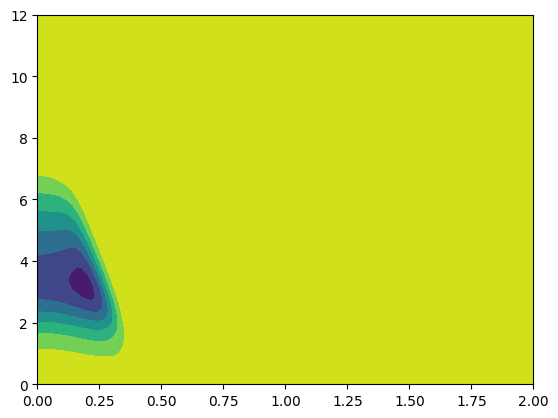

In [6]:
plt.contourf(R0, Z0, tau0)
plt.show()

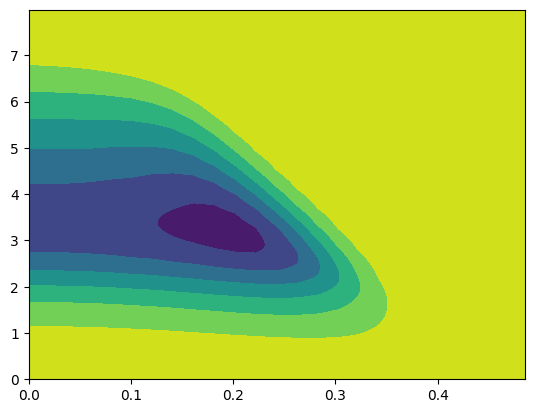

In [7]:
rlim, zlim = 0.5, 8
tau = tau0[:,r<rlim][z<zlim]
Sy_cal = Sy_cal0[:,r<rlim][z<zlim]
jgiv = jgiv0[:,r<rlim][z<zlim]
kext = kext0[:,r<rlim][z<zlim]
Z = Z0[:,r<rlim][z<zlim]
R = R0[:,r<rlim][z<zlim]

A_op = OP_matrix(R.shape[1],dr)

plt.contourf(R, Z, tau)
plt.show()

# $\kappa_{ext}$

100%|██████████| 80000/80000 [03:38<00:00, 366.24it/s]


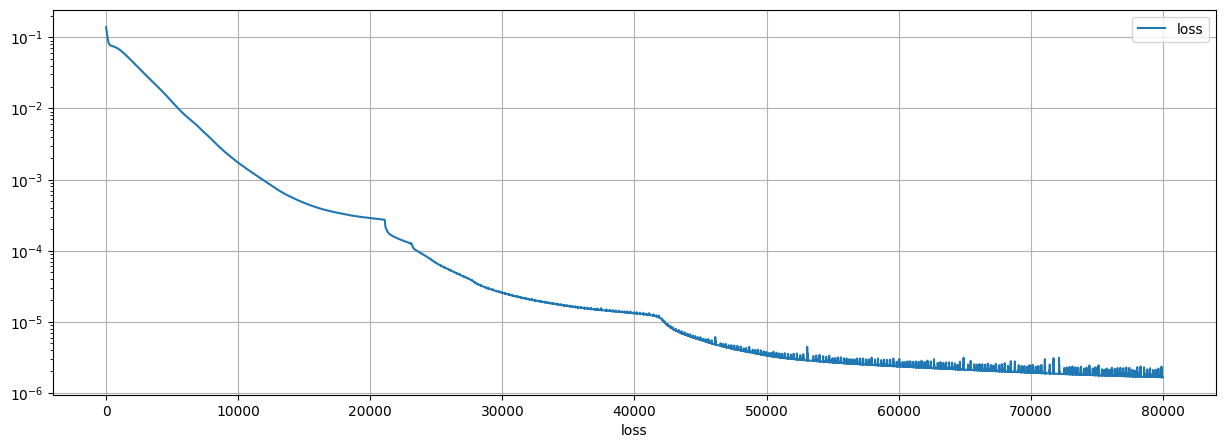

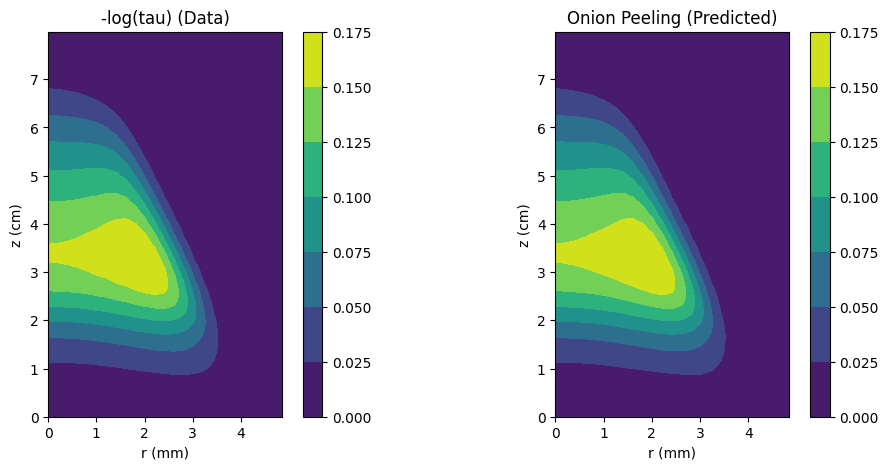

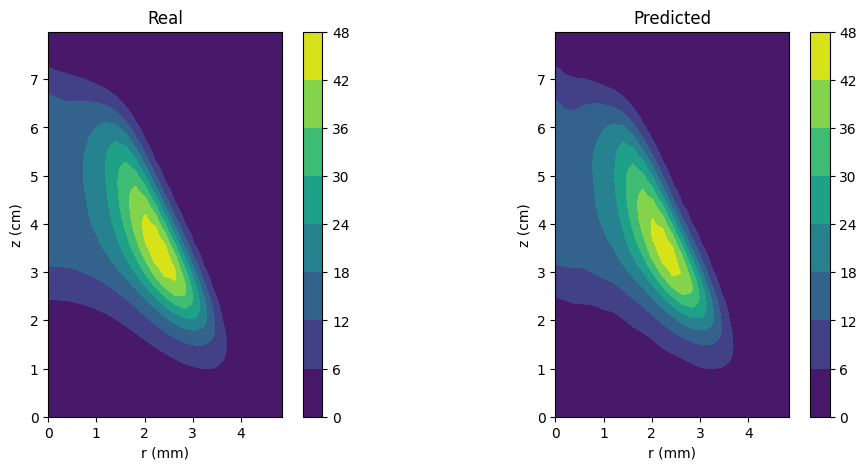

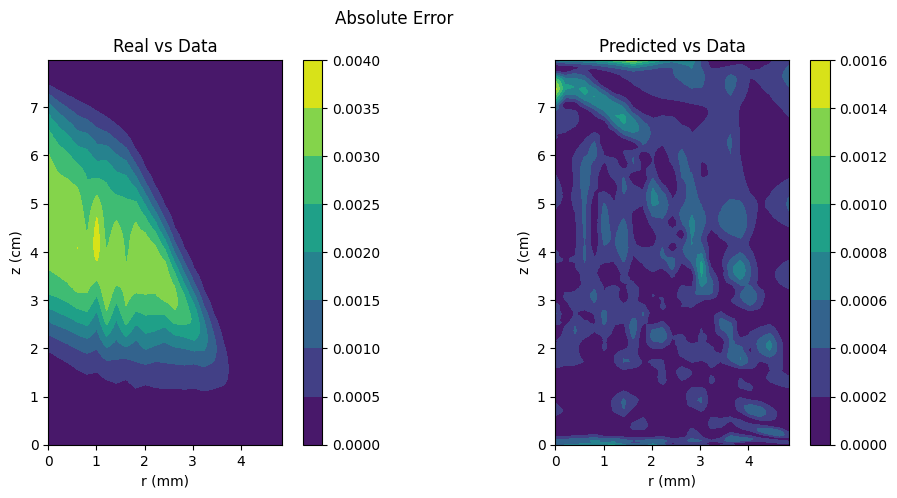

In [8]:
iters = 10000*8
b = -np.log(tau)

coords = np.concatenate([10*R.reshape([-1,1]),Z.reshape([-1,1])], axis=1)
coords = torch.from_numpy(coords).float().to(device)
operator = torch.tensor(A_op).float().to(device)
projected = torch.tensor(b).float().to(device)

abnet = ANNAbel(coords, projected, operator)
abnet.train(iters)

abnet.history_plot()
res = abnet.best.detach().cpu().numpy()
res = np.maximum(res, res[res>0].min())

plt.figure(figsize=(12,5))
plt.subplot(121)
plt.title("-log(tau) (Data)")
plt.contourf(10*R, Z, b)
plt.axis("scaled")
plt.xlabel("r (mm)")
plt.ylabel("z (cm)")
plt.colorbar()
plt.subplot(122)
plt.title("Onion Peeling (Predicted)")
plt.contourf(10*R, Z, (A_op@res.T).T)
plt.axis("scaled")
plt.xlabel("r (mm)")
plt.ylabel("z (cm)")
plt.colorbar()
plt.show()

plt.figure(figsize=(12,5))
plt.subplot(121)
plt.title("Real")
plt.contourf(10*R, Z, kext)
plt.axis("scaled")
plt.xlabel("r (mm)")
plt.ylabel("z (cm)")
plt.colorbar()
plt.subplot(122)
plt.title("Predicted")
plt.contourf(10*R, Z, res)
plt.axis("scaled")
plt.xlabel("r (mm)")
plt.ylabel("z (cm)")
plt.colorbar()
plt.show()

plt.figure(figsize=(12,5))
plt.suptitle("Absolute Error")
plt.subplot(121)
plt.title("Real vs Data")
plt.contourf(10*R, Z, np.abs((A_op@kext.T).T-b))
plt.axis("scaled")
plt.xlabel("r (mm)")
plt.ylabel("z (cm)")
plt.colorbar()
plt.subplot(122)
plt.title("Predicted vs Data")
plt.contourf(10*R, Z, np.abs((A_op@res.T).T-b))
plt.axis("scaled")
plt.xlabel("r (mm)")
plt.ylabel("z (cm)")
plt.colorbar()
plt.show()

# J (without self-attenuation)

100%|██████████| 80000/80000 [03:32<00:00, 376.17it/s]


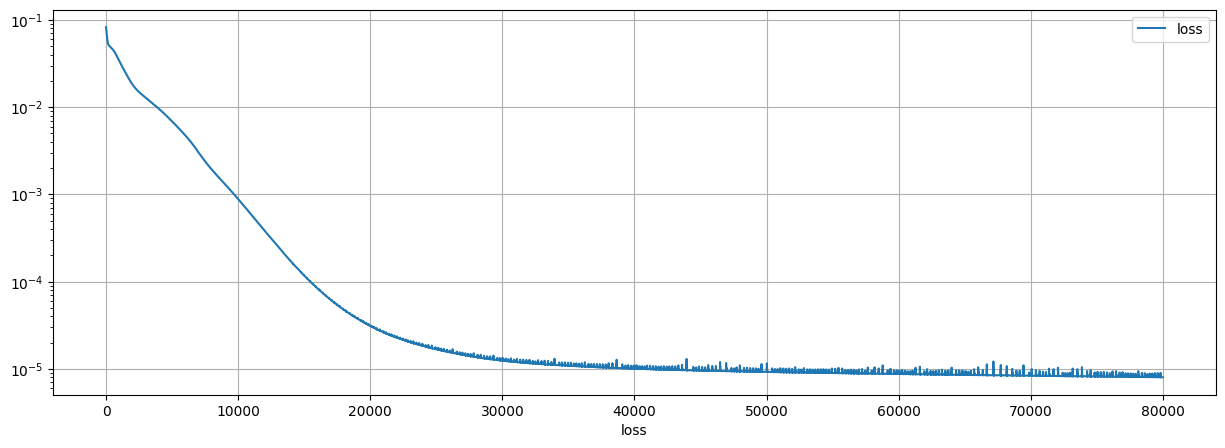

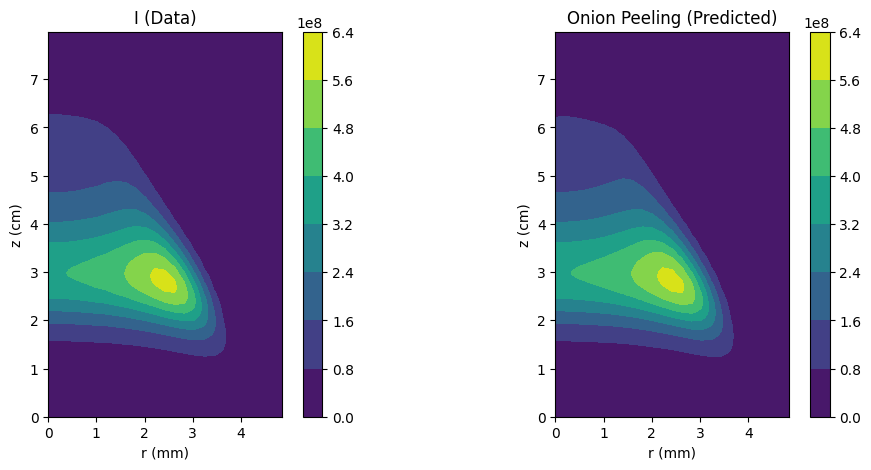

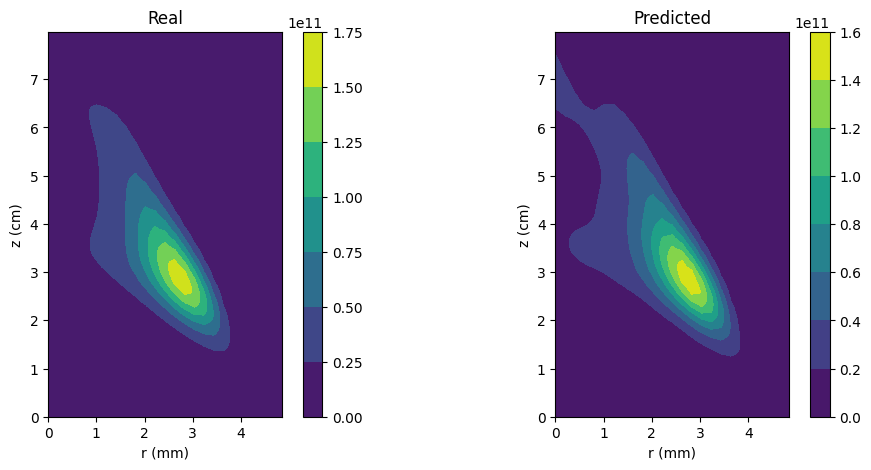

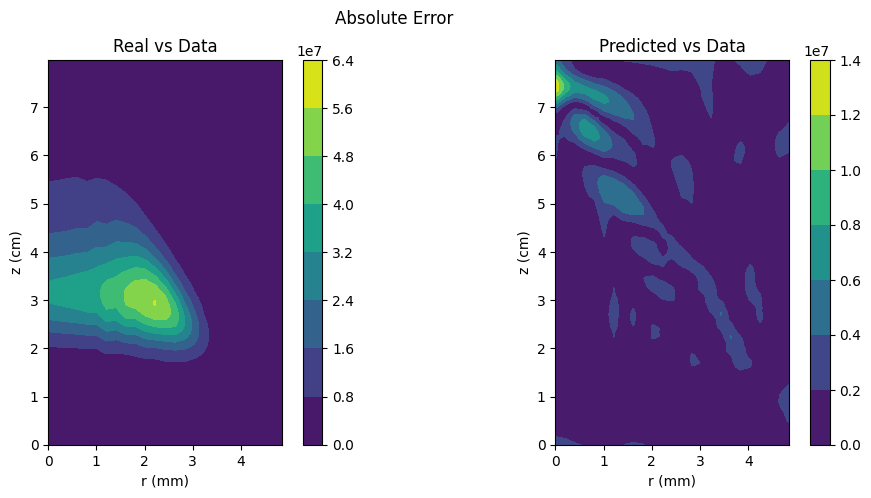

In [9]:
b = Sy_cal

coords = np.concatenate([10*R.reshape([-1,1]),Z.reshape([-1,1])], axis=1)
coords = torch.from_numpy(coords).float().to(device)
operator = torch.tensor(A_op).float().to(device)
projected = torch.tensor(b).float().to(device)

abnet = ANNAbel(coords, projected, operator)
abnet.train(iters)

abnet.history_plot()
res = abnet.best.detach().cpu().numpy()
res = np.maximum(res, res[res>0].min())

plt.figure(figsize=(12,5))
plt.subplot(121)
plt.title("I (Data)")
plt.contourf(10*R, Z, b)
plt.axis("scaled")
plt.xlabel("r (mm)")
plt.ylabel("z (cm)")
plt.colorbar()
plt.subplot(122)
plt.title("Onion Peeling (Predicted)")
plt.contourf(10*R, Z, (A_op@res.T).T)
plt.axis("scaled")
plt.xlabel("r (mm)")
plt.ylabel("z (cm)")
plt.colorbar()
plt.show()

plt.figure(figsize=(12,5))
plt.subplot(121)
plt.title("Real")
plt.contourf(10*R, Z, jgiv)
plt.axis("scaled")
plt.xlabel("r (mm)")
plt.ylabel("z (cm)")
plt.colorbar()
plt.subplot(122)
plt.title("Predicted")
plt.contourf(10*R, Z, res)
plt.axis("scaled")
plt.xlabel("r (mm)")
plt.ylabel("z (cm)")
plt.colorbar()
plt.show()

plt.figure(figsize=(12,5))
plt.suptitle("Absolute Error")
plt.subplot(121)
plt.title("Real vs Data")
plt.contourf(10*R, Z, np.abs((A_op@jgiv.T).T-b))
plt.axis("scaled")
plt.xlabel("r (mm)")
plt.ylabel("z (cm)")
plt.colorbar()
plt.subplot(122)
plt.title("Predicted vs Data")
plt.contourf(10*R, Z, np.abs((A_op@res.T).T-b))
plt.axis("scaled")
plt.xlabel("r (mm)")
plt.ylabel("z (cm)")
plt.colorbar()
plt.show()

# J (with self-attenuation)

100%|██████████| 80000/80000 [03:32<00:00, 376.69it/s]


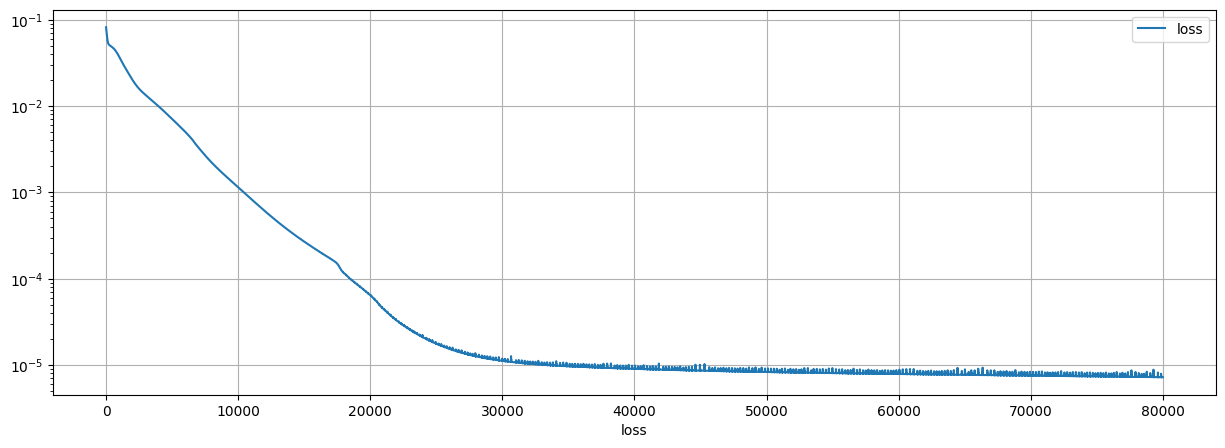

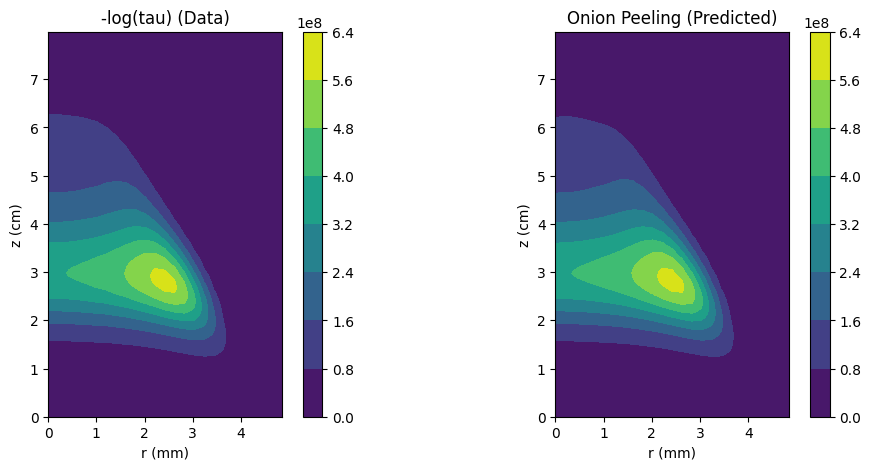

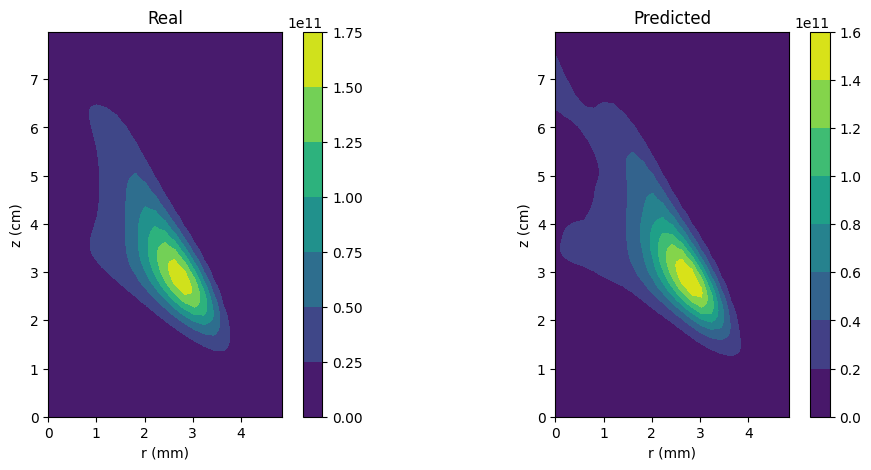

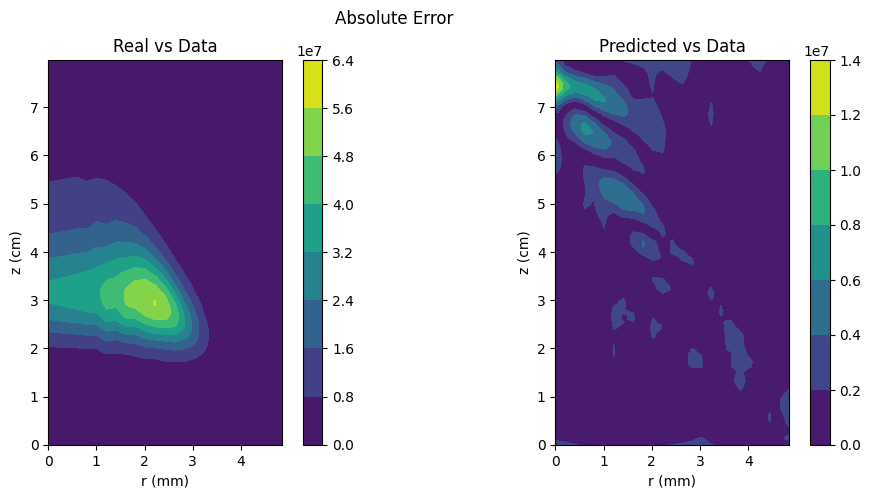

In [10]:
b = Sy_cal

exp = kext.copy()
for j in range(exp.shape[1]):
    exp[:, j] = kext[:,j:].sum(1)*dr
exp = np.exp(-exp)
mat = torch.tensor(exp).float().to(device)

coords = np.concatenate([10*R.reshape([-1,1]),Z.reshape([-1,1])], axis=1)
coords = torch.from_numpy(coords).float().to(device)
operator = torch.tensor(A_op).float().to(device)
projected = torch.tensor(b).float().to(device)

abnet = ANNAbel(coords, projected, operator, mat=mat)
abnet.train(iters)

abnet.history_plot()
res = abnet.best.detach().cpu().numpy()
res = np.maximum(res, res[res>0].min())

plt.figure(figsize=(12,5))
plt.subplot(121)
plt.title("-log(tau) (Data)")
plt.contourf(10*R, Z, b)
plt.axis("scaled")
plt.xlabel("r (mm)")
plt.ylabel("z (cm)")
plt.colorbar()
plt.subplot(122)
plt.title("Onion Peeling (Predicted)")
plt.contourf(10*R, Z, (A_op@(res*exp).T).T)
plt.axis("scaled")
plt.xlabel("r (mm)")
plt.ylabel("z (cm)")
plt.colorbar()
plt.show()

plt.figure(figsize=(12,5))
plt.subplot(121)
plt.title("Real")
plt.contourf(10*R, Z, jgiv)
plt.axis("scaled")
plt.xlabel("r (mm)")
plt.ylabel("z (cm)")
plt.colorbar()
plt.subplot(122)
plt.title("Predicted")
plt.contourf(10*R, Z, res)
plt.axis("scaled")
plt.xlabel("r (mm)")
plt.ylabel("z (cm)")
plt.colorbar()
plt.show()

plt.figure(figsize=(12,5))
plt.suptitle("Absolute Error")
plt.subplot(121)
plt.title("Real vs Data")
plt.contourf(10*R, Z, np.abs((A_op@jgiv.T).T-b))
plt.axis("scaled")
plt.xlabel("r (mm)")
plt.ylabel("z (cm)")
plt.colorbar()
plt.subplot(122)
plt.title("Predicted vs Data")
plt.contourf(10*R, Z, np.abs((A_op@(res*exp).T).T-b))
plt.axis("scaled")
plt.xlabel("r (mm)")
plt.ylabel("z (cm)")
plt.colorbar()
plt.show()

# $I_{bb}$ (with self-attenuation)

100%|██████████| 80000/80000 [03:31<00:00, 378.37it/s]


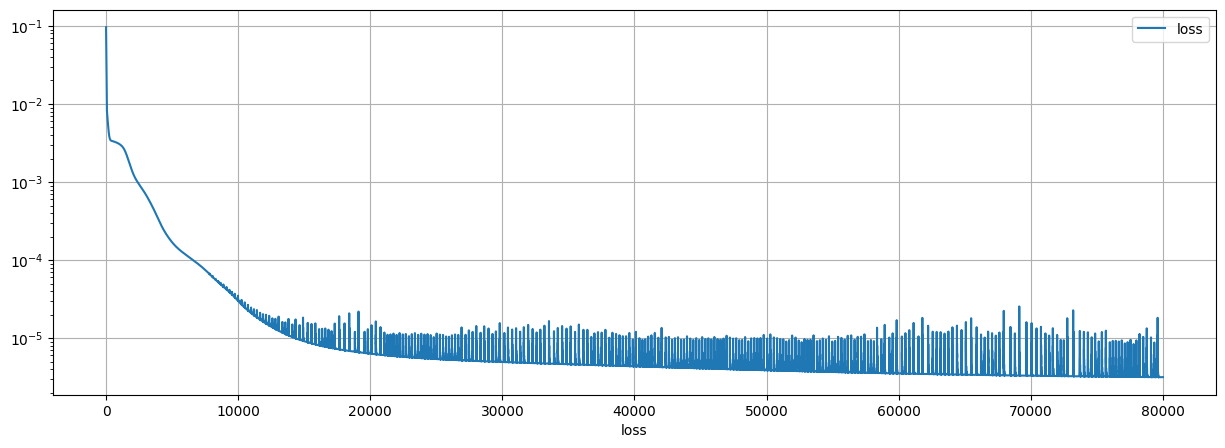

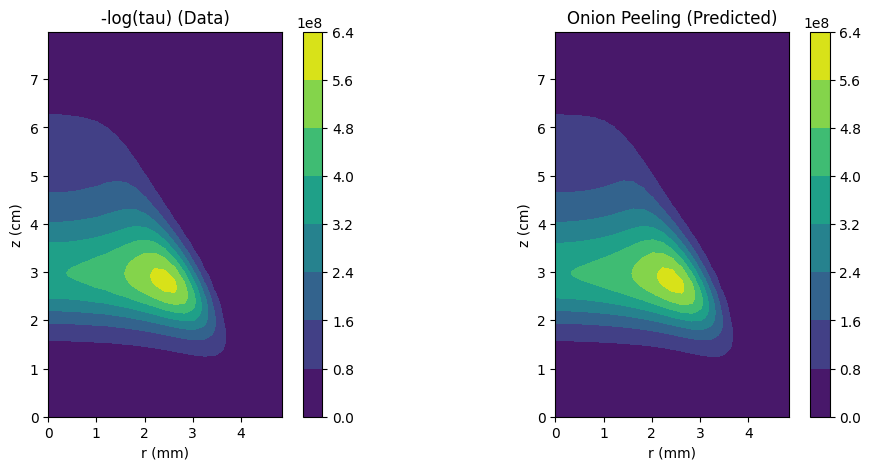

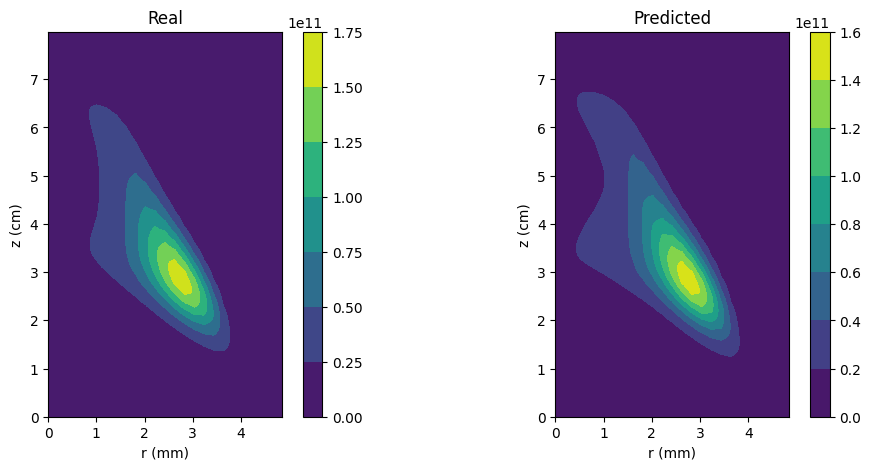

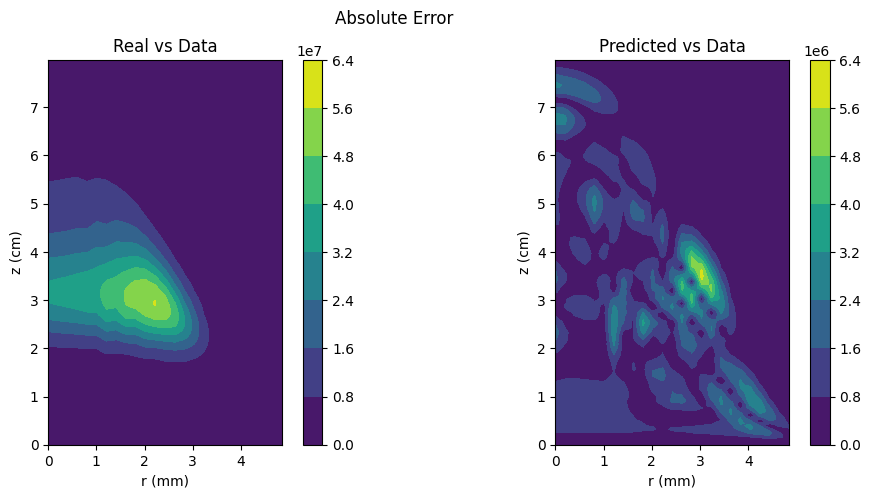

In [11]:
b = Sy_cal

exp = kext.copy()
for j in range(exp.shape[1]):
    exp[:, j] = kext[:,j:].sum(1)*dr
exp = kext*np.exp(-exp)
mat = torch.tensor(exp).float().to(device)

coords = np.concatenate([10*R.reshape([-1,1]),Z.reshape([-1,1])], axis=1)
coords = torch.from_numpy(coords).float().to(device)
operator = torch.tensor(A_op).float().to(device)
projected = torch.tensor(b).float().to(device)

abnet = ANNAbel(coords, projected, operator, mat=mat)
abnet.train(iters)

abnet.history_plot()
res = abnet.best.detach().cpu().numpy()
res = np.maximum(res, res[res>0].min())

plt.figure(figsize=(12,5))
plt.subplot(121)
plt.title("-log(tau) (Data)")
plt.contourf(10*R, Z, b)
plt.axis("scaled")
plt.xlabel("r (mm)")
plt.ylabel("z (cm)")
plt.colorbar()
plt.subplot(122)
plt.title("Onion Peeling (Predicted)")
plt.contourf(10*R, Z, (A_op@(res*exp).T).T)
plt.axis("scaled")
plt.xlabel("r (mm)")
plt.ylabel("z (cm)")
plt.colorbar()
plt.show()

plt.figure(figsize=(12,5))
plt.subplot(121)
plt.title("Real")
plt.contourf(10*R, Z, jgiv)
plt.axis("scaled")
plt.xlabel("r (mm)")
plt.ylabel("z (cm)")
plt.colorbar()
plt.subplot(122)
plt.title("Predicted")
plt.contourf(10*R, Z, res*exp)
plt.axis("scaled")
plt.xlabel("r (mm)")
plt.ylabel("z (cm)")
plt.colorbar()
plt.show()

plt.figure(figsize=(12,5))
plt.suptitle("Absolute Error")
plt.subplot(121)
plt.title("Real vs Data")
plt.contourf(10*R, Z, np.abs((A_op@jgiv.T).T-b))
plt.axis("scaled")
plt.xlabel("r (mm)")
plt.ylabel("z (cm)")
plt.colorbar()
plt.subplot(122)
plt.title("Predicted vs Data")
plt.contourf(10*R, Z, np.abs((A_op@(res*exp).T).T-b))
plt.axis("scaled")
plt.xlabel("r (mm)")
plt.ylabel("z (cm)")
plt.colorbar()
plt.show()

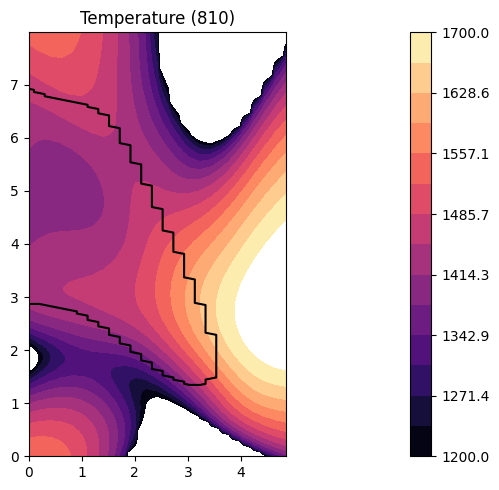

In [12]:
tlevels = np.linspace(1200, 1700, 15)

plt.figure(figsize=(6,5))
T = oneBandTemperature(res, lamb*1e-9)
plt.title(f"Temperature ({lamb})")
plt.contourf(10*R, Z, T, levels=tlevels, cmap="magma")
plt.colorbar()
plt.contour(10*R, Z, (kext>10)*1, levels=[0.5], colors="k")
plt.axis("scaled")
plt.tight_layout()
plt.show()